# Cutting EMD : A different perspective on oscillations with Empirical Mode Decomposition

Before we get started, this tutorial builds on several other resources.

1. The core preprocessing is carried out using OSL batch processing, an efficient wrapper around MNE-Python that enables you to run more prepreprocessing, more quickly and with fewer lines of code. This is a work in progress at the moment but you can read more on the [OSL github page](https://github.com/OHBA-analysis/osl) and the [OSL Workshop Tutorials](https://osf.io/zxb6c/).

2. The EEG we're analysing is from the LEMON dataset

> Babayan, A., Erbey, M., Kumral, D. et al. A mind-brain-body dataset of MRI, EEG, cognition, emotion, and peripheral physiology in young and old adults. Sci Data 6, 180308 (2019). https://doi.org/10.1038/sdata.2018.308

3. We'll be using the Python EMD package available on [PyPI.org](https://pypi.org/project/emd//) and [conda-forge](https://anaconda.org/conda-forge/emd). This package contains a wide [range of tutorials in its documentation](https://emd.readthedocs.io/en/stable/)

We'll start by preparing our python environment, downloading the data and applying some simple preprocessing. Then we can get into some EMD!



# Prologue


---


Let's start by installing some dependencies. OSL will be used for preprocessing and EMD will be our main analysis package. Uncomment and run the lines in the following cell if these aren't already in your environment.

In [1]:
!pip install osl
!pip install emd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 98.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 94.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 17.1 MB/s eta 0:00:00
  Attempting uninstall: importlib-m

Next we'll import a few dependencies ready for analysis

In [82]:
import osl
import mne
import emd
import sails
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, ndimage

Next we'll download some EEG data from the LEMON dataset - this will be downloaded into your working directory, whether it is on colab or your local computer.

In [118]:
import urllib
import os

subj_id = 'sub-010060'  # This is a good dataset to get started with, do come back and try others later!
lemon_url = f'https://ftp.gwdg.de/pub/misc/MPI-Leipzig_Mind-Brain-Body-LEMON/EEG_MPILMBB_LEMON/EEG_Raw_BIDS_ID/{subj_id}/RSEEG/{subj_id}'

for fext in ['eeg', 'vhdr' ,'vmrk']:
    if os.path.exists(f'{subj_id}.{fext}') == False:
        print(f'Downloading : {subj_id}.{fext}')
        urllib.request.urlretrieve(lemon_url + '.' + fext, filename=f'{subj_id}.{fext}')
    else:
        print(f'Found : {subj_id}.eeg')


Found : sub-010060.eeg
Found : sub-010060.eeg
Found : sub-010060.eeg


Next we'll define a couple of functions to use during preprocessing. These are going to be called by the automated preprocessing pipeline in the next cell.

These functions will define an ICA automatic component rejection routine and a function to extract the timing of the eyes open and eyes closed segments of the dataset.

In [119]:
import logging
logger = logging.getLogger('osl')

def lemon_ica(dataset, userargs, logfile=None):
    logger.info('LEMON Stage - custom EEG ICA function')
    logger.info('userargs: {0}'.format(str(userargs)))

    # NOTE: **userargs doesn't work because 'picks' is in there
    ica = mne.preprocessing.ICA(n_components=userargs['n_components'],
                                max_iter=1000,
                                random_state=42)

    # https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#filtering-to-remove-slow-drifts
    fraw = dataset['raw'].copy().filter(l_freq=1., h_freq=None)

    ica.fit(fraw, picks=userargs['picks'])
    dataset['ica'] = ica

    logger.info('starting EOG autoreject')
    # Find and exclude VEOG
    #eog_indices, eog_scores = dataset['ica'].find_bads_eog(dataset['raw'])
    veog_indices, eog_scores =  dataset['ica'].find_bads_eog(dataset['raw'], 'VEOG')
    if len(veog_indices) == 0:
        veog_indices, eog_scores =  dataset['ica'].find_bads_eog(dataset['raw'], 'VEOG', threshold=2)
    dataset['veog_scores'] = eog_scores
    dataset['ica'].exclude.extend(veog_indices)
    logger.info('Marking {0} ICs as EOG {1}'.format(len(dataset['ica'].exclude),
                                                    veog_indices))


   # Save components as channels in raw object
    src = dataset['ica'].get_sources(fraw).get_data()
    veog = src[veog_indices[0], :]

    ica.labels_['top'] = [veog_indices[0]]

    # Apply ICA denoising or not
    if ('apply' not in userargs) or (userargs['apply'] is True):
        logger.info('Removing selected components from raw data')
        dataset['ica'].apply(dataset['raw'])
    else:
        logger.info('Components were not removed from raw data')
    return dataset


def lemon_make_task_regressor(raw):
    ev, ev_id = mne.events_from_annotations(raw)
    print('Found {0} events in raw'.format(ev.shape[0]))
    print(ev_id)

    # Correct for cropping first 10 seconds - not sure why this is necessary?!
    ev[:, 0] -= raw.first_samp

    task = np.zeros((raw.n_times,))
    for ii in range(ev.shape[0]):
        if ev[ii, 2] == ev_id['Stimulus/S200']:
            # EYES OPEN
            task[ev[ii,0]:ev[ii,0]+5000] = 1
        elif ev[ii, 2] == ev_id['Stimulus/S210']:
            # EYES CLOSED
            task[ev[ii,0]:ev[ii,0]+5000] = -1
        elif ev[ii, 2] == 1:
            task[ev[ii,0]] = task[ev[ii,0]-1]

    return task

Next we run the preprocessing chain

In [120]:
# Specify the preprocessing config
config = """
meta:
  event_codes:
preproc:
  - set_channel_types:              {VEOG: eog}
  - crop:                           {tmin: 10, tmax: 360}
  - filter:                         {l_freq: 0.25, h_freq: 150, method: 'iir', iir_params: {order: 5, ftype: butter}}
  - notch_filter:                   {freqs: 50 100}
  - bad_channels:                   {picks: 'eeg'}
  - resample:                       {sfreq: 400}
  - bad_segments:                   {segment_len: 2500, picks: 'eog'}
  - lemon_ica:                      {n_components: 30, picks: eeg}
  - bad_segments:                   {segment_len: 500, picks: 'eeg'}
  - bad_segments:                   {segment_len: 500, picks: 'eeg', mode: 'diff'}
"""
extra_funcs = [lemon_ica]

# Run the preprocessing
fname = f'{subj_id}.vhdr'
dataset = osl.preprocessing.run_proc_chain(config, fname, extra_funcs=extra_funcs)

# Take a copy of the raw object
raw = dataset['raw']
task = lemon_make_task_regressor(raw)

sub-010060 : OSL osl_logger: handler 'console' level set to 'INFO'
sub-010060 : LEMON Stage - custom EEG ICA function
sub-010060 : userargs: {'n_components': 30, 'picks': 'eeg'}
sub-010060 : starting EOG autoreject
sub-010060 : Marking 2 ICs as EOG [3, 2]
sub-010060 : Removing selected components from raw data
Found 162 events in raw
{'Stimulus/S  1': 1, 'Stimulus/S200': 200, 'Stimulus/S210': 210}


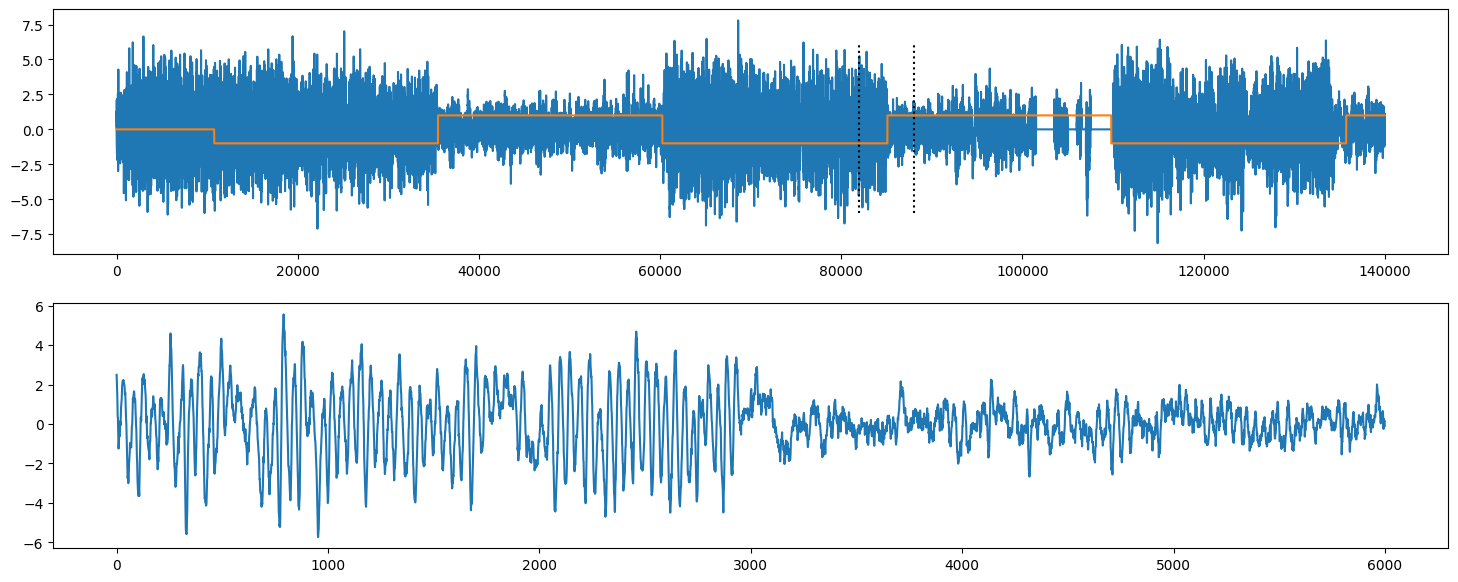

In [121]:
xx = raw.get_data(reject_by_annotation='NaN', picks=['Oz'])[0, :] * 1e5
xx[np.isnan(xx)] = 0
timex = raw.times

yy = xx[82000:88000]
tasky = task[82000:88000]
timey = timex[82000:88000]


plt.figure(figsize=(18, 7))
plt.subplot(211)
plt.plot(xx)
plt.plot(task)
plt.plot((82000, 82000), (-6, 6), 'k:')
plt.plot((88000, 88000), (-6, 6), 'k:')
plt.subplot(212)
plt.plot(yy)

# The Sift Algorithm



---



Right, now we're ready to find some oscillations!

Here is the original reference for the sift algorithm

> Norden E. Huang, Zheng Shen, Steven R. Long, Manli C. Wu, Hsing H. Shih, Quanan Zheng, Nai-Chyuan Yen, Chi Chao Tung & Henry H. Liu (1998) The empirical mode decomposition and the Hilbert spectrum for nonlinear and non-stationary time series analysis. Proceedings of the Royal Society of London. Series A: Mathematical, Physical and Engineering Sciences 10.1098/rspa.1998.0193

Now would be a good time to check out the [sift tutorials](https://emd.readthedocs.io/en/stable/emd_tutorials/index.html#sifting) on the EMD package website if you haven't already...


Let's take a look at our dataset. First we will run a standard sift with the default settings.


In [122]:
imf = emd.sift.sift(yy)

The output `imf` is an array with time samples on the first dimension and IMFs on the seconds.

In [175]:
print(imf.shape)

(6000, 9)


We can see that the algorithm has identified 9 IMFs from the data. Let's take a closer look at them... using the `emd.plotting.plot_imfs` function.

<Axes: xlabel='Time (samples)'>

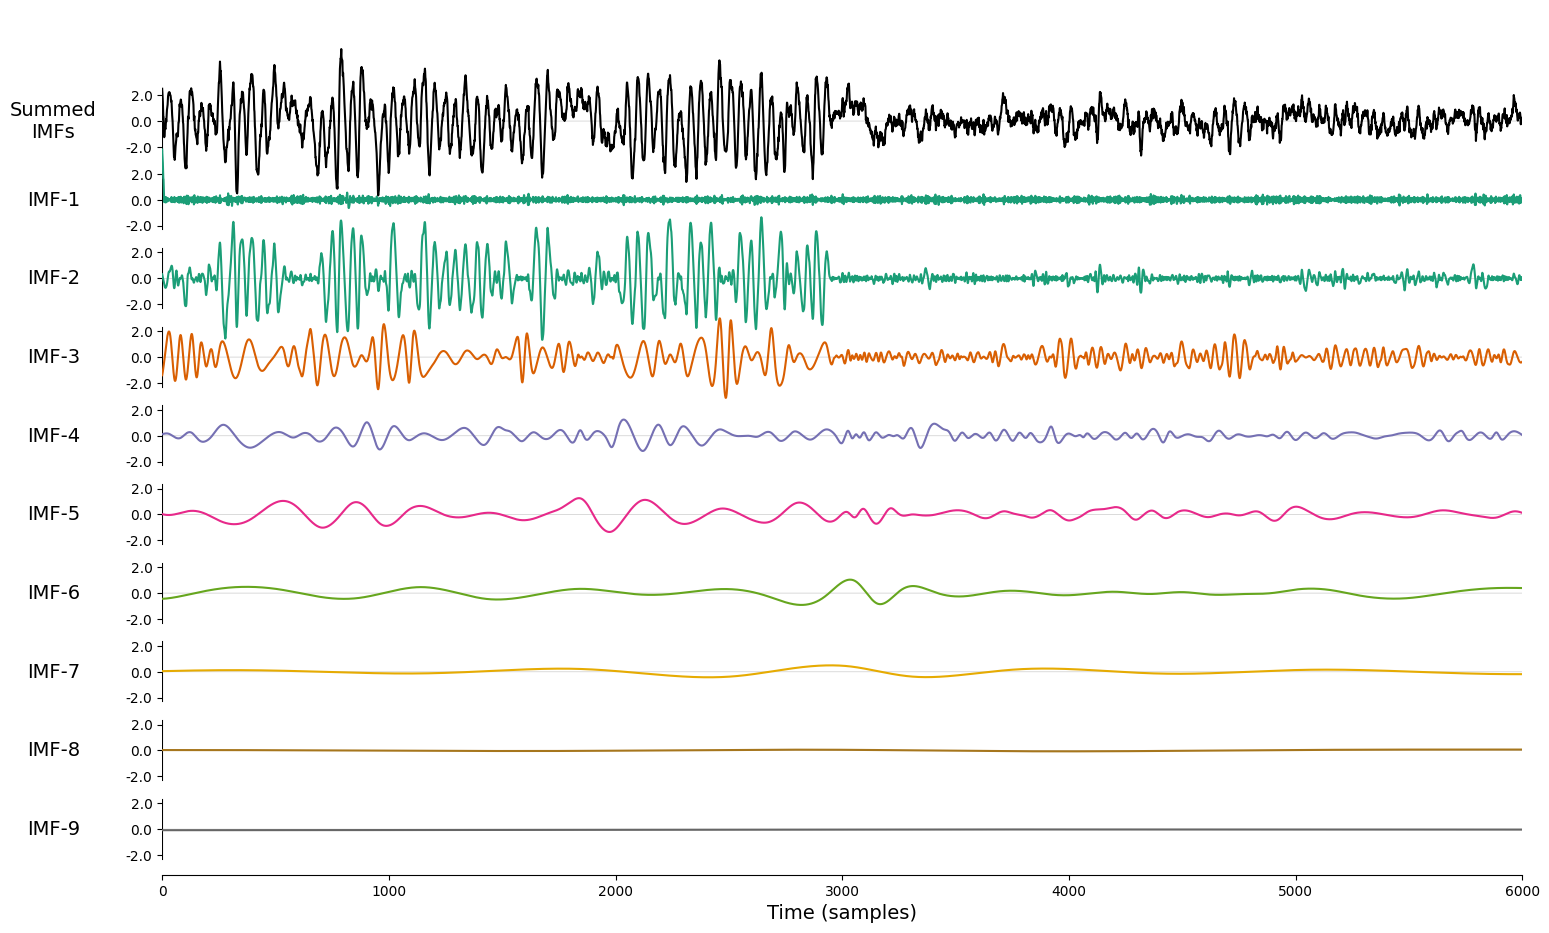

In [176]:
emd.plotting.plot_imfs(imf)

Take a moment to look over the plot. What do you think?

---

It is certainly clear to see the correspondence between the orignal time series and the IMFs. All of the features in the original dataset are visible in one or more of the estimated components.

However... there are a couple of issues:

Firstly, it isn't the case that the alpha oscillation is contained within a single componet. Rather, it is spread out between IMF-2 and IMF-3. This is not an intuitive result. We would have to combine these components or combine subsequent analysis across them to continue out analysis.

Secondly, it would be hard to call these components a Hilbert transform friendly 'monocomponent' signal. Take a look at IMF-2. The first half of the signal has clear patches of alpha oscillations but the second half of the signal is strongly characterised by much faster, low amplitude signal.

These issues arise from dynamics in the noise of the dataset. Some points in time require 2 IMFs to describe the noise at higher frequencies than alpha, whereas other points only need 1. This causes mixing of frequency content between IMFs.

Whilst the total representation of signal energy across instantaneous frequency across all IMFs will be valid. We can't zoom into a single oscillatory component in a single IMF, so we continue with this decomposition.

# The Mask-Sift

---

The mask sift is a potential solution to the mode-mixing problem. It makes use of a user defined set of 'mask' signals that act as a lower bound for the frequency content that can be contained within an IMF.

A recent innovation is the interated masked sift which provides a method for automating selection of mask frequencies based on a simple heuristic. In short, mask frequencies are iteratively updated to minimise the distance between the mask frequency and the average instantaneous frequency of the IMF.

Now would be a good time to have a look at the [mask sift tutorial](https://emd.readthedocs.io/en/stable/emd_tutorials/01_sifting/emd_tutorial_01_sift_04_masksift.html#sphx-glr-emd-tutorials-01-sifting-emd-tutorial-01-sift-04-masksift-py) and [iterated mask sift tutorial](https://emd.readthedocs.io/en/stable/emd_tutorials/01_sifting/emd_tutorial_01_sift_05_iterated_masksift.html#sphx-glr-emd-tutorials-01-sifting-emd-tutorial-01-sift-05-iterated-masksift-py) in the EMD documentation.

Here are some core references for the mask sift

**Original Reference**
> Ryan Deering & James F. Kaiser (2005)
The Use of a Masking Signal to Improve Empirical Mode Decomposition
2005 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP) 10.1109/icassp.2005.1416051

**Example Applications**
> Feng-Fang Tsai, Shou-Zen Fan, Yi-Shiuan Lin, Norden E. Huang & Jia-Rong Yeh (2016)
Investigating Power Density and the Degree of Nonlinearity in Intrinsic Components of Anesthesia EEG by the Hilbert-Huang Transform: An Example Using Ketamine and Alfentanil
PLOS-ONE 10.1371/journal.pone.0168108

> Quinn, Andrew J., Lopes-dos-Santos, Vítor, Huang, Norden, Liang, Wei-Kuang, Juan, Chi-Hung, Yeh, Jia-Rong, Nobre, Anna C., Dupret, David, Woolrich & Mark W. (2021)
Within-cycle instantaneous frequency profiles report oscillatory waveform dynamics
Journal of Neurophysiology 10.1152/jn.00201.2021

**Iterated Mask Sift**
> Marco S. Fabus, Andrew J. Quinn, Catherine E. Warnaby & Mark W. Woolrich (2021)
Automatic decomposition of electrophysiological data into distinct nonsinusoidal oscillatory modes
Journal of Neurophysiology 10.1152/jn.00315.2021


In this tutorial, we're going to jump in with the Iterated Mask Sift. This should optimise our mask placements in a way that gives a good separation of oscillatory components into separate IMFs. Let's try out the iterated mask sift on the short segment of our EEG data...


In [182]:
mimf = emd.sift.iterated_mask_sift(xx, max_imfs=5,
                                   mask_amp_mode='ratio_sig', # Scale each mask's amplitude by the whole signal
                                   )


<Axes: xlabel='Time (samples)'>

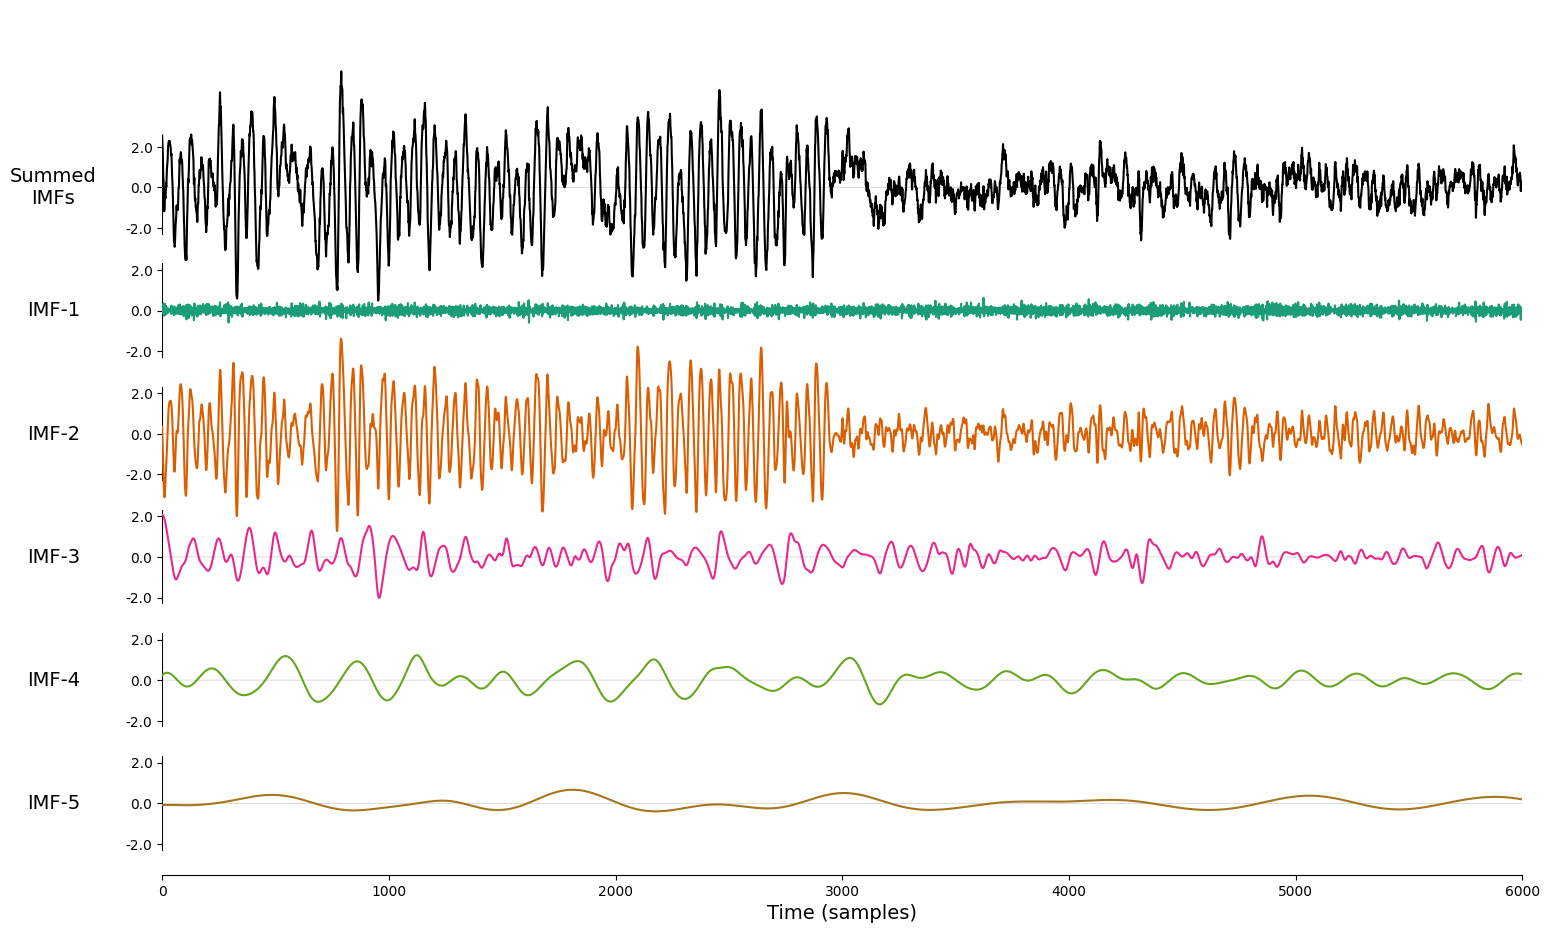

In [183]:
emd.plotting.plot_imfs(mimf[82000:88000, :])

Take a look over the plot. What do you think?

---

I think this is much better! The alpha oscillation is largely contained within IMF-1, which is now much closer to a 'monocomponent' signal, though it is noisy where there is no strong alpha signal in the data.

The other IMFs are have clearly separate frequency content and any mixing has been substantially reduced.

The EMD should be able to preserve non-linear structure within IMFs, we can inspect this by plotting the standard Fourier spectrum of the alpha IMF.

Text(0.5, 1.0, "Welch's Periodogram of a short IMF segment\nduring eyes closed rest")

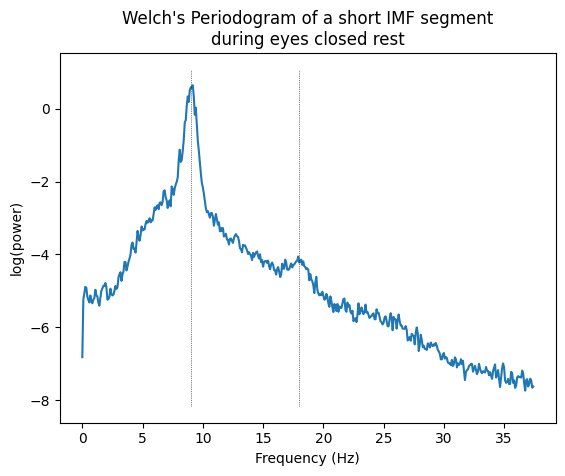

In [184]:
f, pxx = signal.welch(mimf[:, 1], fs=raw.info['sfreq'], nperseg=raw.info['sfreq']*12)
plt.plot(f[:450], np.log(pxx[:450]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('log(power)')
yl = plt.ylim()

# Add indicators for harmonic freqs
plt.plot((9, 9), yl, 'k:', lw=0.5)
plt.plot((18, 18), yl, 'k:', lw=0.5)

plt.title("Welch's Periodogram of a short IMF segment\nduring eyes closed rest")

There is a large peak visible at 9Hz as well as a harmonic at 18Hz. The presence of this harmonic in the Fourier spectrum is a clear indication that the IMF contains some level of non-linear structures.

We can zoom into this by looking at the instantaneous frequency content of our IMFs.

# Instantaneous Frequency and Hilbert-Huang Spectra

---

[Instantaneous phase and frequency](https://en.wikipedia.org/wiki/Instantaneous_phase_and_frequency) are central concepts for the EMD. The whole purpose of the sift is to identify components that permit reliable Hilbert transforms so we can compute these instantaneous signal characteristics.

Now would be a good time to check out the [Hilbert-Huang Transform](https://emd.readthedocs.io/en/stable/emd_tutorials/02_spectrum_analysis/emd_tutorial_02_spectrum_01_hilberthuang.html#sphx-glr-emd-tutorials-02-spectrum-analysis-emd-tutorial-02-spectrum-01-hilberthuang-py) tutorial on the EMD documentation.

**Core Instantaneous Frequency Reference**
> Norden E. Huang, Zhaohua Wu, Steven R. Long, Kenneth C. Arnold, Xianyao Chen & Karin Blank (2009) On Instantaneous Frequency
Advances in Adaptive Data Analysis 10.1142/s1793536909000096

Next we'll compute the instantaneous frequency transform using the 'Normalised Hilbert Transform' method. We apply a small amount of phase smoothing to stablise the instantaneous frequency computation.


In [193]:
IP, IF, IA = emd.spectra.frequency_transform(mimf, raw.info['sfreq'], 'nht', smooth_phase=11)

Each of the values IP, IF and IA is the same size as the input imf and contains the estimates for the instantaneous phase, frequency and amplitude respectively.

Let's take a look at the phase and frequency.

Text(0, 0.5, 'Frequency (Hz)')

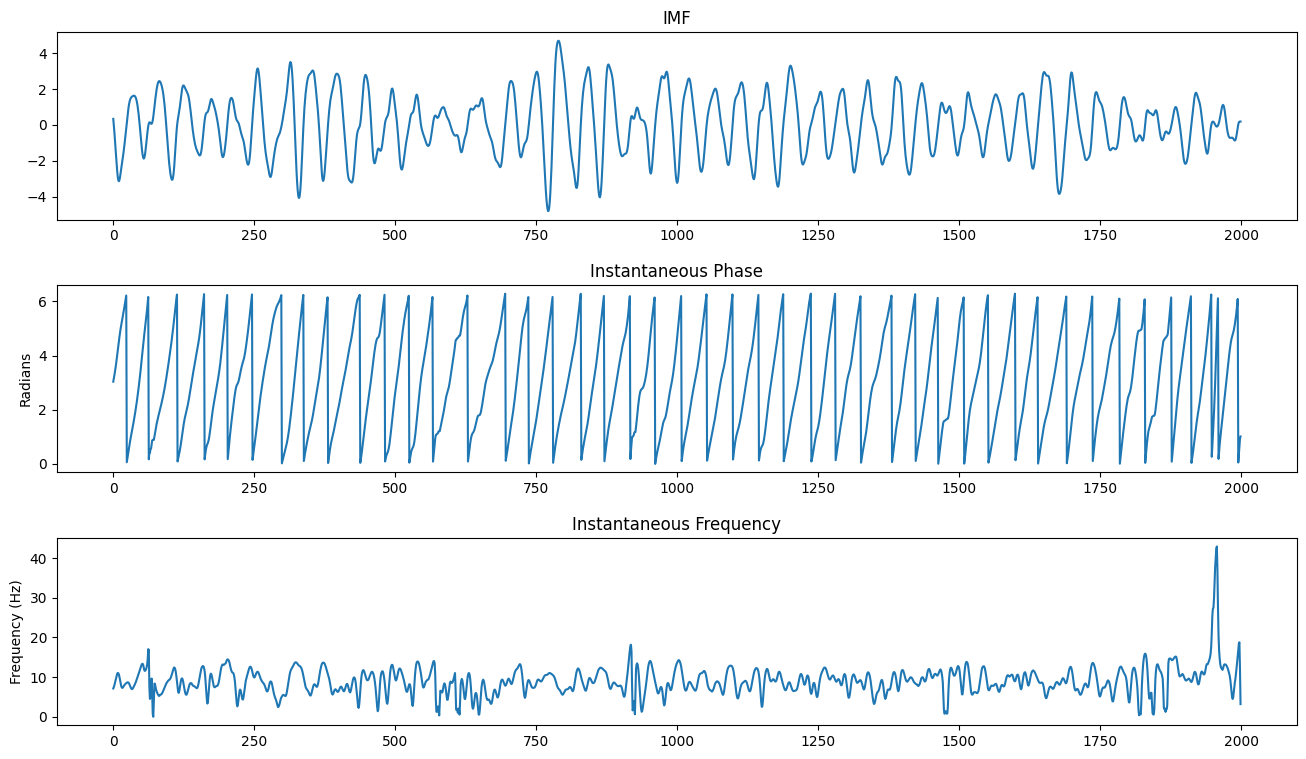

In [199]:
plt.figure(figsize=(16, 9))
plt.subplots_adjust(hspace=0.35)
plt.subplot(311)
plt.plot(mimf[82000:84000, 1])
plt.title('IMF')
plt.subplot(312)
plt.plot(IP[82000:84000, 1])
plt.title('Instantaneous Phase')
plt.ylabel('Radians')
plt.subplot(313)
plt.plot(IF[82000:84000, 1])
plt.title('Instantaneous Frequency')
plt.ylabel('Frequency (Hz)')

The phase clearly tracks the cyclical structure of the IMF. Some cycles have more linear phase profiles than others reflecting variability in waveform shape. This is also apparent in the instantaneous frequency which is computed from the differential of the instantaneous phase.

We can use these values to compute a spectrum using the Hilbert-Huang Transform. This is simply a histogram of the instantaneous frequency values in each IMF weighted by their corresponding instantaneous amplitudes. Let's take a look at an example by computing the HHT for the eyes open and eyes closed segments of out IMFs.

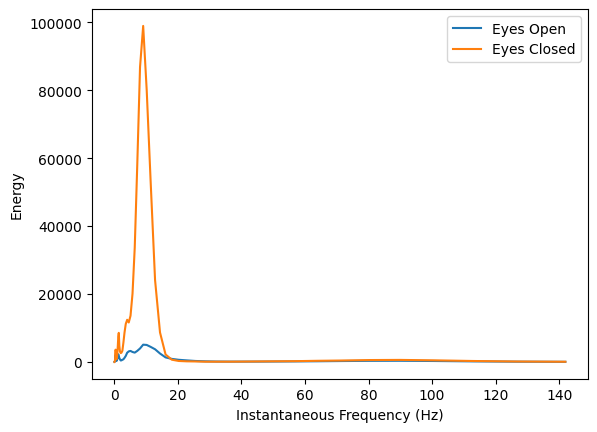

In [202]:
# Get time segments of interest
open_inds = task==1
closed_inds = task==-1

# Define histogram bins (start, stop, num_steps, scaling)
fbins = (0.1, 150, 64, 'log')

# Compute HHT
f, pxx_open = emd.spectra.hilberthuang(IF[open_inds], IA[open_inds], fbins)
f, pxx_closed = emd.spectra.hilberthuang(IF[closed_inds], IA[closed_inds], fbins)

plt.figure()
plt.plot(f, pxx_open)
plt.plot(f, pxx_closed)
plt.xlabel('Instantaneous Frequency (Hz)')
plt.ylabel('Energy')
plt.legend(['Eyes Open', 'Eyes Closed'])

The HHT reproduces the eyes open vs eyes closed power difference as we'd expect. However, averaging across such large periods of time does not make the most of the precision of the EMD. A time-frequency HHT does a better job.

We can compute this in the same way as before, but now we specificy that we don't want to average the HHT over time. We also apply as small amout of gaussian smoothing to make the HHT effects easier to see.

In [212]:
f, hht = emd.spectra.hilberthuang(IF, IA, (0.1, 45, 64, 'linear'), sum_time=False)
hht = ndimage.gaussian_filter(hht, 1)

We will also compare our HHT to a standard Morlet Wavelet transform computed on the same frequencies.

In [213]:
import sails

cwt = sails.wavelet.morlet(xx, f, raw.info['sfreq'])

Let's visualise the results!

Text(0.5, 1.0, 'Hilbert Huang Trasnform')

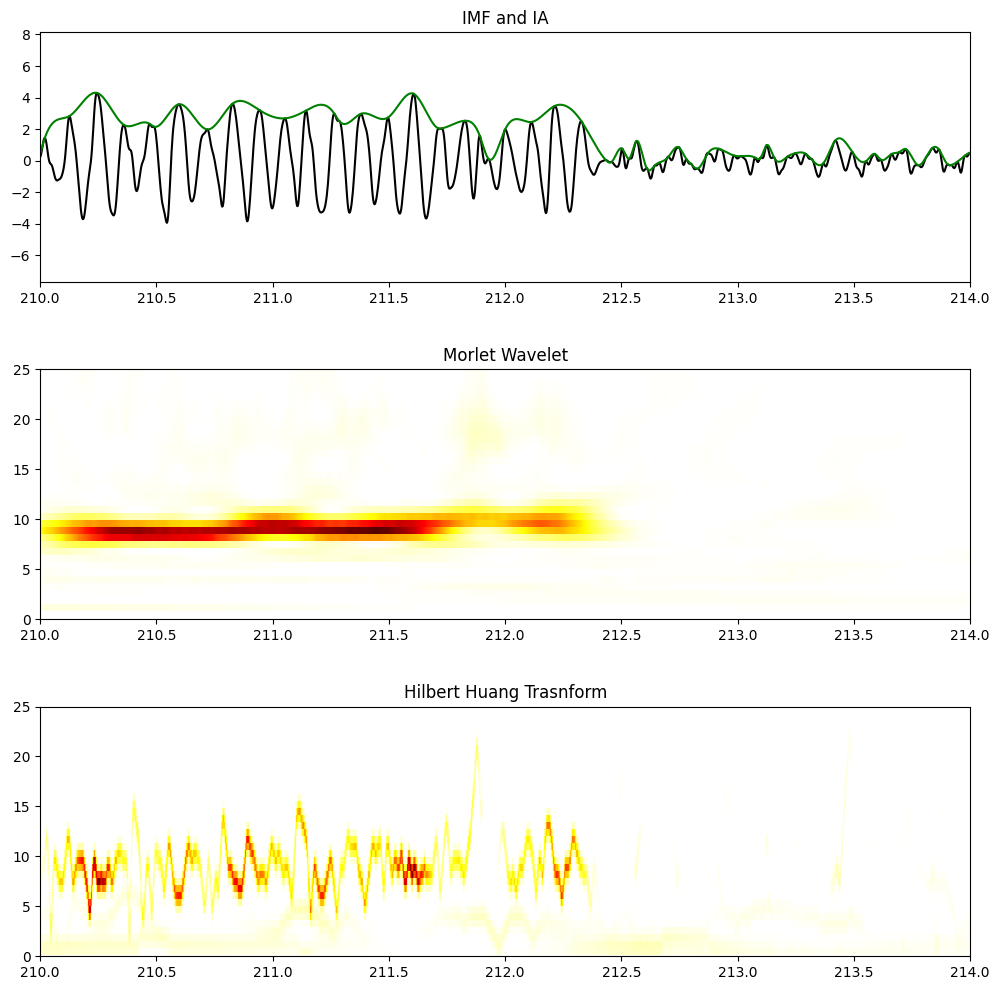

In [218]:
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.35)
plt.subplot(311)
plt.plot(timex, mimf[:, 1], 'k')
plt.plot(timex, IA[:, 1], 'g')
plt.title('IMF and IA')
plt.xlim(210, 214)
plt.subplot(312)
plt.pcolormesh(timey, f, cwt[:, 82000:88000], cmap='hot_r', shading='nearest')
plt.ylim(0, 25)
plt.xlim(210, 214)
plt.title('Morlet Wavelet')
plt.subplot(313)
plt.pcolormesh(timey, f, hht[:, 82000:88000], cmap='hot_r', shading='nearest')
plt.ylim(0, 25)
plt.xlim(210, 214)
plt.title('Hilbert Huang Trasnform')


We can clearly see the improvement in temporal and spectral resolution in the HHT. There are much larger fluctuations in frequency over time. The HHT values vary quickly between values of around 5 and 15, whereas the wavelet transform says around 9Hz for the duration.

Some parts of the HHT appear to decrease in amplitude at unexpected points. This happens when there are very fast dynamics in instantaneous frequency and the corresponding amplitude values get spread out over a wide frequency range in the histogram, reducing their apparent density. In contrast, relatively sinusoidal cycles have stable instantaneous frequency profiles that all multiple amplitude values to contribute to a single histogram bin. The total IA is unchanged.

# Single Cycle Analysis

---


We can futher use the instantaneous phase as the basis for a single-cycle analysis.

Now would be a good time to check out the [cycle analysis tutorials](https://emd.readthedocs.io/en/stable/emd_tutorials/index.html#cycle-analysis) in the EMD documentation.

This analysis type follows the methods in this paper.

> Quinn, A. J., Lopes-dos-Santos, V., Huang, N., Liang, W.-K., Juan, C.-H., Yeh, J.-R., Nobre, A. C., Dupret, D., & Woolrich, M. W. (2021). Within-cycle instantaneous frequency profiles report oscillatory waveform dynamics. In Journal of Neurophysiology (Vol. 126, Issue 4, pp. 1190–1208). American Physiological Society. https://doi.org/10.1152/jn.00201.2021

You can see an example of a cycle analysis in action on this github repo.: https://github.com/OHBA-analysis/Quinn2021_Waveform/blob/main/emd_waveform_0_analysis.py#L76


Firstly, we initialise a `Cycles` class using the instantaneous phase timecouse of our alpha IMF.

In [232]:
C = emd.cycles.Cycles(IP[:, 1])

This class detects the phase jumps and positions of every cycle in the IMF and computes some simple checks to see if that cycle is likely to be 'good'. A good cycle is defined as having a phase that spans the whole 2pi range without any jumps or reversals, though it may have non-linearities within in.

We can see those values by extracting the cycle metrics as a pandas dataframe

In [233]:
C.get_metric_dataframe()


,is_good
0,0
1,1
2,1
3,1
4,1
...,...
3426,0
3427,1
3428,0
3429,1


We can see that we have a value for the metric 'is_good' for every cycle. Most of these are '1's but some cycles fail our checks and we may choose to reject them from future analyses.

We can add any cycle metric that we want by calling `C.compute_cycle_metric`. This takes in a name for the matrix, a vector of values to compute the metric from and a function that computes the metric. The cycles class will step through each cycle, extract the values from the vector corresponding to that cycle and pass it into the function to compute the value. Let's compute a few examples.

In [234]:
# Compute which task state the cycle is in
C.compute_cycle_metric('TaskCond', task, np.mean)

# Compute the mean amplitude of each alpha cycle
C.compute_cycle_metric('MeanAmp', IA[:, 1], np.mean)

# Compute the mean instantaneous frequency of each alpha cycle
C.compute_cycle_metric('MeanIF', IF[:, 1], np.mean)



C.get_metric_dataframe()


,is_good,TaskCond,MeanAmp,MeanIF
0,0,0.0,1.844436,61.062602
1,1,0.0,1.693979,9.164869
2,1,0.0,2.301642,9.505229
3,1,0.0,0.244828,8.806847
4,1,0.0,3.206810,9.748500
...,...,...,...,...
3426,0,1.0,0.292943,5.008759
3427,1,1.0,0.363216,8.415875
3428,0,1.0,0.159553,5.968012
3429,1,1.0,0.318337,24.788645


We might want to restrict our analyses to certain subsets of the cycles that we have computed, we do this by specifying a set of logical conditions using the values contained within our metric dataframe.

Here we filter out a subset of cycles, taking only those that are good, have IF between 4 and 20Hz and amplitude above 0.2.

In [235]:
conditions=['is_good==1', 'MeanIF>4', 'MeanIF<20', 'MeanAmp>0.2']
dff = C.get_metric_dataframe(conditions=conditions)

We can visualise the extracted cycles by plotting the frequency and amplitude of each cycle from both the full dataset and the subset.

Text(0, 0.5, 'Cycle Avg Inst. Amplitude')

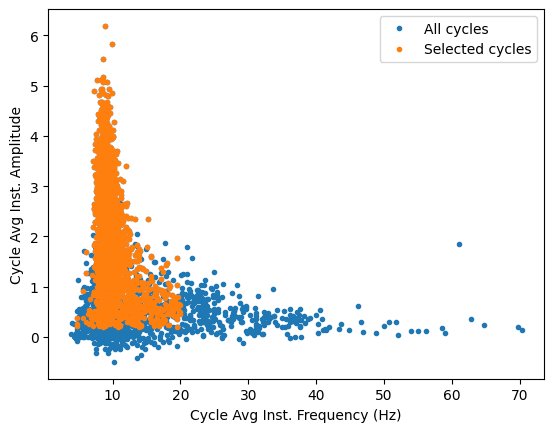

In [224]:
plt.figure()
plt.plot(df['MeanIF'], df['MeanAmp'], '.')
plt.plot(dff['MeanIF'], dff['MeanAmp'], '.')
plt.legend(['All cycles', 'Selected cycles'])
plt.xlabel('Cycle Avg Inst. Frequency (Hz)')
plt.ylabel('Cycle Avg Inst. Amplitude')

We can futher sub-divide the data into task states. Here we extract the cycles from each resting condition and plot them separately. This shows a single cycle analysis perspective on the alpha increase when a participant closes their eyes.

Text(0, 0.5, 'Cycle Avg Inst. Amplitude')

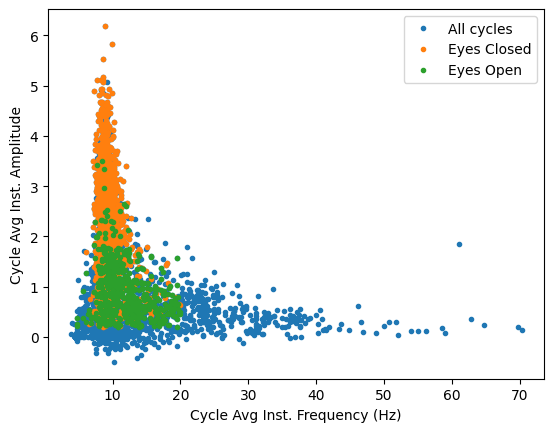

In [236]:
dff_open = C.get_metric_dataframe(conditions=conditions + ['TaskCond==1'])
dff_closed = C.get_metric_dataframe(conditions=conditions + ['TaskCond==-1'])

plt.figure()
plt.plot(df['MeanIF'], df['MeanAmp'], '.')
plt.plot(dff_closed['MeanIF'], dff_closed['MeanAmp'], '.')

plt.plot(dff_open['MeanIF'], dff_open['MeanAmp'], '.')
plt.legend(['All cycles', 'Eyes Closed', 'Eyes Open'])
plt.xlabel('Cycle Avg Inst. Frequency (Hz)')
plt.ylabel('Cycle Avg Inst. Amplitude')

# We're finished!

Thank you for running through these tutorials. Please have a look through the [EMD documentation](https://emd.readthedocs.io/en/stable/index.html) for more information, tutorials and examples!